In [ ]:
#@title Install prerequsite: you may have to do Runtime -> Restart runtime after the installation

!pip install --upgrade "mxnet<2.0.0"
!pip install botocore autogluon

     |████████████████████████████████| 55.0MB 74kB/s 
  Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1
     |████████████████████████████████| 6.7MB 4.3MB/s 
     |████████████████████████████████| 624kB 46.5MB/s 
     |████████████████████████████████| 133kB 50.3MB/s 
     |████████████████████████████████| 102kB 12.1MB/s 
     |████████████████████████████████| 102kB 9.8MB/s 
     |████████████████████████████████| 2.1MB 29.6MB/s 
     |████████████████████████████████| 28.6MB 151kB/s 
     |████████████████████████████████| 112kB 41.1MB/s 
     |████████████████████████████████| 890kB 39.0MB/s 
     |████████████████████████████████| 819kB 36.3MB/s 
     |████████████████████████████████| 2.6MB 48.1MB/s 
     |████████████████████████████████| 665kB 36.7MB/s 
     |████████████████████████████████| 215kB 49.7MB/s 
     |████████████████████████████████| 66.2MB 51kB/s 
     |██████████████████████████████

In [ ]:
# try out if you can load autogluon ok, if not, try restart your runtime and 
# redo the installation

import autogluon

In [ ]:
#@title Mount Google Drive (You don't need to run this if you are running notebooks on your laptop)

from google.colab import drive

# The following command will prompt a URL for you to click and obtain the
# authorization code

drive.mount("/content/drive")


Mounted at /content/drive


In [ ]:
# Set up data folder
from pathlib import Path

# Change this to where you put your hw2 files
DATA = Path("/content/drive/My Drive/Colab Notebooks/")

# Assignment: Classification and Characterization of Data

## Classifying COVID-19 infection using AutoML




We have done differential expression between COVID-19 vs other viral and non-viral acute respiratory illnesses (ARIs) in Problem 1, HW2A. As we see a distinct transcriptomic pattern in COVID-19 infected samples, we will try to build a binary classification model, that given an transcriptomic profile of an upper airway sample, the model can predict whether this sample is infected by COVID-19 or not.

I will use use the log2 CPM values generated from DGEList to build the model, with data: [ua_gse156063_cpm.txt](https://drive.google.com/file/d/1XJwvrxuBCsk8pne4ByGGPfeHmBF86ri8/view?usp=sharing)

Meta data is loaded, and then I extract sample IDs that match the column names of the expression table as the first 12 characters in the sample title.

In [ ]:
import pandas as pd

gefile = DATA / "ua_gse156063_cpm.txt"
metafile = DATA / "GSE156063_characteristics.txt"

ge = pd.read_csv(gefile, sep="\t", index_col=0)
meta = pd.read_csv(metafile, sep="\t")
meta["sample_id"] = meta.sample_title.str[:12]

In [ ]:
meta.head()

,sample_title,sars-cov-2_pcr,gender,age,geo_accession,disease_state,sars-cov-2_rpm,sample_id
0,RR057e_00253_M12_S189,0.041795,M,51.0,GSM4721600,other virus,NEG,RR057e_00253
1,RR057e_00231_K12_S187,0.294782,F,44.0,GSM4721707,no virus,NEG,RR057e_00231
2,RR057e_00508_C04_S51,0.094097,M,49.0,GSM4721665,no virus,NEG,RR057e_00508
3,RR057i_00157_D15_S228,889882.176583,F,76.0,GSM4721596,SC2,POS,RR057i_00157
4,RR057e_00427_I08_S121,0.071005,F,67.0,GSM4721702,other virus,NEG,RR057e_00427


Let's see how samples we have per each class

In [ ]:
meta.groupby("disease_state").sample_id.nunique()

disease_state
SC2             93
no virus       100
other virus     41
Name: sample_id, dtype: int64

### Split test set

Now is the definition of the test set to be held out from model building process. Given that there are much fewer samples in `other virus` class, it would not be reasonable to enforce having equal number in each class in training set. Instead, I will sample equal proportion from each class as training and testing.

For this, I will pick 20% of each class as the test set.

In [ ]:
import numpy as np
# set the seed to ensure reproducibility
np.random.seed(4060)
# from each class pick 20% of the samples as test set
test_samples = meta.groupby("disease_state").apply(
    lambda x: x.sample(frac=0.2)
).sample_id.values

In [ ]:
# define train and test set
meta["subset"] = "train"
meta.loc[meta.sample_id.isin(test_samples), "subset"] = "test"

As a sanity check, let's see how many samples we have in each class after the split:

In [ ]:
meta.groupby(["subset", "disease_state"]).sample_id.nunique()

subset  disease_state
test    SC2              19
        no virus         20
        other virus       8
train   SC2              74
        no virus         80
        other virus      33
Name: sample_id, dtype: int64

### Feature selection

Similar to what was done in class - feature selection using `MultiTaskLassoCV` for building a model.

In [ ]:
#=================================================
# Your code here
# Perform feature selection using MultiTaskLassoCV
from sklearn.linear_model import MultiTaskLassoCV
from sklearn.preprocessing import OneHotEncoder
#=================================================

In [ ]:
# OHE matrix
encoder = OneHotEncoder()
target = encoder.fit_transform(meta[["disease_state"]])

In [ ]:
# Training and Testing Data
x_train = ge[meta[meta.subset == "train"].sample_id].transpose()
y_train = target[(meta.subset == "train").values].toarray()
x_test = ge[meta[meta.subset == "test"].sample_id].transpose()
y_test = target[(meta.subset == "test").values].toarray()

In [ ]:
# Perform MultiTaskLassoCV
lassocv = MultiTaskLassoCV().fit(x_train, y_train)

In [ ]:
pd.DataFrame(lassocv.coef_)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,15453,15454,15455,15456,15457,15458,15459,15460,15461,15462,15463,15464,15465,15466,15467,15468,15469,15470,15471,15472,15473,15474,15475,15476,15477,15478,15479,15480,15481,15482,15483,15484,15485,15486,15487,15488,15489,15490,15491,15492
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# count how many genes was selected across all disease states

((lassocv.coef_ != 0).sum(axis=0) != 0).sum()

80

From the above function, we can see that 80 genes were selected by the Lasso models.

#### Genes selected by the Lasso models are entered into the [MSigDB website](https://www.gsea-msigdb.org/gsea/msigdb/annotate.jsp). Options chosen are `H: hallmark gene sets`, `C2: curated gene sets`, and `C7: immunologic signature gene sets`, and leave the rest as default. Among the gene sets reported to be enriched, are there any gene sets you find that are related to respiratory system / diseases?

In [ ]:
lassocv.coef_

(3, 15493)

In [ ]:
lasso_selections = np.where((lassocv.coef_ != 0).sum(axis=0) > 0)
lasso_selections

(array([  253,   506,  1209,  1317,  1770,  1803,  1995,  2079,  2152,
         2209,  2380,  2658,  2698,  2992,  3054,  3211,  3212,  3526,
         3816,  3831,  3930,  4042,  4281,  4291,  4427,  4681,  4874,
         5213,  5309,  5321,  5401,  5474,  5519,  5524,  5589,  5609,
         5641,  5845,  6047,  6077,  6085,  6140,  6165,  6528,  6543,
         6730,  6970,  6974,  7003,  7079,  7359,  7602,  7779,  7865,
         7968,  8097,  8109,  8175,  8721,  9104,  9309,  9362,  9424,
        10841, 10873, 10914, 10915, 11427, 11820, 11988, 12477, 12695,
        13211, 13434, 13602, 13686, 13910, 14407, 14606, 14905]),)

In [ ]:
ge.head()

,RR057e_00253,RR057e_00231,RR057e_00508,RR057i_00157,RR057e_00427,RR057e_00741,RR057e_00586,RR057e_00549,RR057e_00504,RR057e_00401,RR057i_00064,RR057e_00239,RR057e_00488,RR057e_00727,RR057e_00268,RR057e_00759,RR057e_00748,RR057e_00107,RR057i_00137,RR057e_00119,RR057i_00062,RR057i_00120,RR057e_00726,RR057i_00131,RR057e_00161,RR057i_00081,RR057e_00224,RR057e_00515,RR057e_00505,RR057e_00733,RR057e_00051,RR057e_00088,RR057e_00744,RR057e_00076,RR057i_00163,RR057i_00080,RR057e_00074,RR057e_00168,RR057e_00491,RR057e_00206,...,RR057e_00743,RR057e_00752,RR057e_00454,RR057e_00130,RR057e_00516,RR057e_00577,RR057e_00142,RR057i_00098,RR057e_00080,RR057i_00180,RR057e_00440,RR057e_00260,RR057e_00747,RR057e_00399,RR057e_00073,RR057e_00324,RR057i_00104,RR057e_00309,RR057i_00075,RR057i_00086,RR057i_00094,RR057e_00294,RR057i_00108,RR057i_00106,RR057e_00039,RR057e_00273,RR057i_00158,RR057e_00494,RR057i_00095,RR057e_00203,RR057e_00216,RR057e_00202,RR057i_00114,RR057e_00761,RR057i_00096,RR057e_00736,RR057i_00072,RR057i_00175,RR057e_00116,RR057i_00078
A1BG,3.3895,4.3247,1.0815,2.6302,3.4676,-1.6094,3.0835,0.7981,1.3385,3.1307,0.8569,3.5388,3.3830,2.7075,-0.0622,3.6461,3.2491,3.0845,4.2962,5.1269,0.9919,1.7798,3.0217,3.6693,4.4358,2.7666,4.3443,2.7554,4.1754,-0.5479,2.8551,2.3095,2.6260,3.2932,3.2947,4.1572,3.2185,3.6714,3.8747,1.9102,...,3.1500,3.4603,4.0349,2.7085,3.6635,3.4693,3.9488,3.3948,3.9321,3.6004,3.2452,0.4918,3.7239,3.3997,2.2276,0.7066,2.8015,2.9130,3.0769,2.7666,-1.6094,3.7441,1.8251,2.9678,-1.6094,3.0391,3.2190,3.8771,3.2567,4.3627,4.3345,3.2783,2.3835,3.4034,3.0224,3.6202,2.9906,2.3771,2.7813,3.0524
A1CF,1.7220,2.6350,2.9033,-1.6094,1.1702,-1.6094,-1.6094,1.1125,-1.6094,-1.6094,2.2564,1.7255,1.3893,0.4455,-1.6094,1.4866,0.2909,2.9640,1.2180,0.4780,3.8800,-0.2423,1.7240,1.0693,2.6470,0.6612,2.6953,0.0230,2.7498,-1.6094,-1.6094,-1.6094,1.3333,1.0204,1.1022,1.8363,-1.6094,1.5165,1.7550,-1.6094,...,1.5483,1.0869,2.2354,1.9928,2.2351,1.0531,1.8114,0.8347,2.2964,0.9675,0.8239,-1.6094,0.6604,2.3294,1.4582,2.0841,0.5211,1.0900,2.5658,1.6606,-1.6094,-1.4078,2.7568,-1.6094,-1.6094,2.2364,2.2689,0.9700,0.2226,4.2100,1.5724,1.5619,1.4384,2.1888,0.2560,1.5425,1.4511,1.9191,-1.6094,1.2718
A2M,5.5584,5.0045,5.6555,4.9819,4.7248,5.2409,6.2807,6.9811,4.6170,5.7709,-1.6094,6.1807,4.8850,5.0625,5.3453,6.7780,6.0478,5.2367,5.5430,8.5940,5.4434,5.1509,4.6098,5.9728,4.2231,6.2273,4.9287,7.7823,6.0200,6.0182,6.1870,5.5898,4.9968,4.5932,3.5401,5.0899,3.7864,3.8340,4.8703,6.2279,...,6.2978,4.6253,5.1045,5.4036,5.2027,4.2168,3.4508,4.0304,5.0513,4.1625,4.4165,3.1628,6.4946,4.2466,6.3597,4.4056,3.7672,4.1968,4.5909,4.2595,6.6551,5.0033,1.8251,5.1672,5.8661,2.4826,5.2330,4.3727,3.5940,4.2100,4.6706,6.1359,4.8029,5.0247,4.6698,3.6644,4.4139,4.6516,5.6167,5.1468
A2ML1,2.9553,4.1445,3.2126,1.1905,4.2413,2.1492,7.3150,3.4099,5.5407,4.2304,-1.6094,2.6623,2.8999,4.6222,-0.0622,3.4207,2.7700,2.8998,3.1410,2.6289,5.2680,5.3100,4.5674,3.1986,5.2821,3.0474,9.4634,6.6325,5.3177,-0.5479,3.3586,5.5429,3.6723,5.0393,3.1544,6.0409,4.0697,3.5362,4.1996,4.8822,...,3.3315,3.3517,2.5065,7.0302,6.4670,2.7962,5.7731,4.3721,4.3323,3.3700,4.1586,2.9777,3.7043,3.3220,4.8997,10.4640,5.9874,5.5031,5.4487,4.6683,5.2479,2.7686,5.5029,2.5728,-1.6094,3.3181,1.8862,3.0522,5.6869,3.9262,3.7255,3.2019,2.4177,3.4896,4.3090,3.6425,3.6585,3.8694,-1.6094,1.9041
A4GALT,5.6105,6.1484,5.6033,4.8897,6.3582,4.1105,6.0339,5.5600,6.3141,6.5725,5.8252,5.8368,6.5333,5.8638,6.3945,4.9704,5.7142,3.6112,3.9370,4.8622,5.9748,6.6621,5.8187,6.0738,4.0922,6.3132,6.2354,6.1071,5.7738,6.2654,4.6402,7.4740,6.3732,6.4837,6.7007,5.6885,5.0555,5.8974,6.4425,6.4981,...,5.6531,6.1260,3.3992,4.0354,6.7861,5.5619,5.9319,6.3026,4.9445,5.9085,5.9260,5.0305,5.8070,5.4364,6.0995,6.9477,7.0575,5.9649,5.1860,6.1117,6.1930,5.7755,5.5029,3.7490,7.9195,6.4010,5.9770,5.6764,5.5385,6.0449,4.8632,5.7265,5.3779,6.3920,5.9302,6.5048,6.1289,6.1716,6.7153,5.6827


In [ ]:
selected = ge.iloc[lasso_selections]
selected.shape

(80, 234)

In [ ]:
selected.index.values

array(['ADAT3', 'ALOX15B', 'BACE2', 'BEST4', 'CACNA1E', 'CALHM6',
       'CCDC81', 'CCL8', 'CD1E', 'CD163L1', 'CEMIP', 'CLCA2', 'CLEC10A',
       'CPNE5', 'CRLF1', 'CXCL9', 'CXCL10', 'DGKI', 'DTL', 'DUOXA2',
       'ECT2L', 'EIF3CL', 'ERVMER34-1', 'ESR1', 'FAM71A', 'FCGR1B',
       'FOXO3B', 'GLI2', 'GOLGA6L1', 'GOLGA8N', 'GPR84', 'GRIN2B',
       'GSTA2', 'GSTM1', 'GZMB', 'H2AC18', 'H3C4', 'HLA-DQA2', 'ICAM4',
       'IFI6', 'IFI44L', 'IGLL5', 'IL1R2', 'KCNC4', 'KCNH7', 'KLHDC8A',
       'LGI1', 'LGR6', 'LIMS2', 'LPAR4', 'MAP1B', 'MESP1', 'MMP19',
       'MRC1', 'MS4A1', 'MUC2', 'MUC19', 'MYO1H', 'NRCAM', 'P3H4',
       'PCSK5', 'PDGFRB', 'PERM1', 'RGPD2', 'RHCG', 'RIMBP3B', 'RIMBP3C',
       'SCGB3A1', 'SIX5', 'SLC23A1', 'SPECC1L-ADORA2A', 'STATH', 'TGM3',
       'TMEM63C', 'TMPRSS9', 'TNS3', 'TRO', 'UTY', 'WDR74', 'ZFP91-CNTF'],
      dtype=object)

From searching through MSIGDB and the 60 resulting overlaps, I did not find a lot of gene sets that were related to the respiratory system or diseases. However, the second hit on the database (BOSCO_TH1_CYTOTOXIC_MODULE) was a gene with 7 genes overlap that represented Th1 / cytotoxic module in sputnum during asthma exacerbations, which is exactly what the question asks for. Another gene set that was close to a top hit, with 7 genes in overlap, is BLANCO_MELO_COVID19_SARS_COV_2_POS_PAT_PATIENT_LUNG_TISSUE_UP, which is a gene strongly upregulated in the lung tissue of post-mortem COVID-19 vs uninfected. Other genes involve diseases such as cancers (mainly breast cancer), human embryonic stem cell proteins, leukemia, and/or dendritic cells. 

### Training a COVID-19 infection classifier using AutoML

Train a multi-class classification model using AutoGluon.

In [ ]:
#======================================================================
# Train a classification model using AutoGluon TabularPrediction module
from autogluon import TabularPrediction as task
#======================================================================

In [ ]:
import numpy as np

y_pred_score = lassocv.predict(x_test)
y_pred_score = (np.exp(y_pred_score).T / np.exp(y_pred_score).sum(axis=1)).T
y_pred = y_pred_score.argmax(axis=1)

In [ ]:
gene_idx = (lassocv.coef_ != 0).sum(axis=0) != 0

# Create training data using only the selected genes
train_data = task.Dataset(x_train.loc[:, gene_idx].copy())
train_data["disease_state"] = meta.loc[meta.subset == "train",
                                     "disease_state"].values
label_column = "disease_state"

Once the model is trained, I can evaluate my model using performance scores 
from class.

In [ ]:
from sklearn.metrics import (accuracy_score, balanced_accuracy_score, 
                             roc_auc_score, f1_score)
def performance_scores(y_true, y_pred_score, y_pred=None):
    # We can find which class has the highest score as its predicted class
    if y_pred is None:
        y_pred = y_pred_score.argmax(axis=1)
        
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "balanced_accuracy": balanced_accuracy_score(y_true, y_pred),
        "auroc": roc_auc_score(y_true, y_pred_score, average="weighted",
                               multi_class="ovr"),
        "f1": f1_score(y_true, y_pred, average="weighted")
    }

In [ ]:
#===========================================================
# Calculate the multi-class performance scores of your model

predictor = task.fit(train_data=train_data, label=label_column,
                     presets="good_quality_faster_inference_only_refit",
                     output_directory="good_quality")
#===========================================================

Beginning AutoGluon training ...
AutoGluon will save models to good_quality/
AutoGluon Version:  0.0.14
Train Data Rows:    187
Train Data Columns: 80
Preprocessing data ...
AutoGluon infers your prediction problem is: 'multiclass' (because dtype of label-column == object).
	3 unique label values:  ['other virus', 'no virus', 'SC2']
	If 'multiclass' is not the correct problem_type, please manually specify the problem_type argument in fit() (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
NumExpr defaulting to 2 threads.
Train Data Class Count: 3
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    12597.66 MB
	Train Data (Original)  Memory Usage: 0.12 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dtypes of the features.
	Stage 1 Generators:
		Fitting AsTypeFeatureGenerator...
	Stag

In [ ]:
predictor.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                                         model  score_val  pred_time_val   fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0                      weighted_ensemble_k0_l1   0.925134       0.615602  19.616512                0.000592           0.227520            1      False         10
1               NeuralNetClassifier_STACKER_l0   0.919786       0.086188   7.287868                0.086188           7.287868            0      False          1
2              LightGBMClassifierXT_STACKER_l0   0.914439       0.013783   1.266207                0.013783           1.266207            0      False          7
3          ExtraTreesClassifierEntr_STACKER_l0   0.887701       0.511973   3.136584                0.511973           3.136584            0      False          5
4                LightGBMClassifier_STACKER_l0   0.882353       0.013131   1.590834                0.013131           1.590834  

{'feature_prune': False,
 'hyperparameter_tune': False,
 'hyperparameters_userspecified': {'default': {'CAT': [{}],
   'GBM': [{}, {'AG_args': {'name_suffix': 'XT'}, 'extra_trees': True}],
   'NN': [{}],
   'RF': [{'AG_args': {'name_suffix': 'Gini',
      'problem_types': ['binary', 'multiclass']},
     'criterion': 'gini',
     'max_depth': 15},
    {'AG_args': {'name_suffix': 'Entr',
      'problem_types': ['binary', 'multiclass']},
     'criterion': 'entropy',
     'max_depth': 15}],
   'XT': [{'AG_args': {'name_suffix': 'Gini',
      'problem_types': ['binary', 'multiclass']},
     'criterion': 'gini',
     'max_depth': 15},
    {'AG_args': {'name_suffix': 'Entr',
      'problem_types': ['binary', 'multiclass']},
     'criterion': 'entropy',
     'max_depth': 15}],
   'custom': [{'AG_args': {'disable_in_hpo': True,
      'model_type': 'GBM',
      'name_suffix': 'Custom'},
     'boosting_type': 'gbdt',
     'feature_fraction': 0.9,
     'learning_rate': 0.03,
     'min_data_in_leaf

In [ ]:
test_data = task.Dataset(x_test.loc[:,gene_idx].copy())
y_pred_score = predictor.predict_proba(test_data)
performance_scores(y_test.argmax(axis=1), y_pred_score)

{'accuracy': 0.8297872340425532,
 'auroc': 0.9038309995756804,
 'balanced_accuracy': 0.7407894736842104,
 'f1': 0.8136778115501521}

I can also calculate scores if I only consider whether the sample is infected by SC2 or not, similar to what was done in class for cancer vs normal prediction

In [ ]:
#===========================================================================
# Calculate the binary performance scores of your model considering only SC2
# vs non-SC2
y_test_bin = (y_test[:, encoder.categories_[0] == "SC2"] == 1).flatten().astype(int)
y_pred_score_bin = y_pred_score[:, encoder.categories_[0] == "SC2"]
y_pred_bin = (y_pred == (encoder.categories_[0] == "SC2").argmax()).astype(int)
performance_scores(y_test_bin, y_pred_score_bin, y_pred=y_pred_bin)
#===========================================================================

{'accuracy': 0.8936170212765957,
 'auroc': 0.9210526315789475,
 'balanced_accuracy': 0.893796992481203,
 'f1': 0.894013787630809}

When it is a binary model then the accuracies are easier to achieve higher values as shown here, where both accuracy and balanced accuracy are improved from original.



Now I can also plot a confusion matrix to show correct and incorrect predictions in three classes:

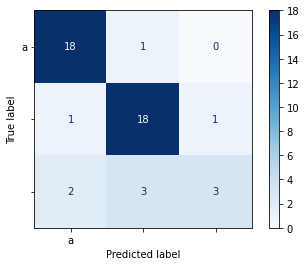

In [ ]:
#============================================
# Plot confusion matrix for all three classes
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test.argmax(axis=1),
                      y_pred_score.argmax(axis=1))

disp = ConfusionMatrixDisplay(cm, display_labels = encoder.categories[0])
disp.plot(cmap = "Blues")
#============================================